# WHS CHD MICCAI19 Dataset

In [ ]:
import os
import torch
from tqdm.notebook import tqdm

ROOT_DIR = "./.."
os.chdir(ROOT_DIR)
DATA_PATH = "./data/datasets/CHD68_segmentation_dataset_miccai19"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_map = {
    "background": {"color": "black", "value": 0.0},
    "left ventricle": {"color": "yellow", "value": 1.0, "description": "the left ventricle blood cavity"},
    "right ventricle": {"color": "skyblue", "value": 2.0, "description": "the right ventricle blood cavity"},
    "left atrium": {"color": "red", "value": 3.0, "description": "the left atrium blood cavity"},
    "right atrium": {"color": "purple", "value": 4.0, "description": "the right atrium blood cavity"},
    "myocardium": {"color": "blue", "value": 5.0, "description": "the myocardium of the left ventricle"},
    "ascending aorta": {"color": "orange", "value": 6.0, "description": "the ascending aorta"},
    "pulmonary artery": {"color": "green", "value": 7.0, "description": "the pulmonary artery"},
}

label_values = [meta["value"] for meta in label_map.values()]
colors = [meta["color"] for meta in label_map.values()]

## Dataset

In [2]:
dataset = {"train": [], "val": [], "test": [], "size": 0}

def collect_images_labels(image_dir, label_dir, postfix=""):
    images = []
    labels = []
    for path in sorted(os.listdir(image_dir)):
        if path.endswith(f"image{postfix}"):
            images.append(os.path.join(image_dir, path))

    for path in sorted(os.listdir(label_dir)):
        if path.endswith(f"label{postfix}"):
            labels.append(os.path.join(label_dir, path))

    dataset = []    
    for images, labels in zip(images, labels):
        dataset.append({"image": images, "label": labels, "label_map": label_map})
    
    return dataset

data = collect_images_labels(DATA_PATH, DATA_PATH, postfix=".nii.gz.128128128.npy")
data[0]

{'image': './data/datasets/CHD68_segmentation_dataset_miccai19/ct_1001_image.nii.gz.128128128.npy',
 'label': './data/datasets/CHD68_segmentation_dataset_miccai19/ct_1001_label.nii.gz.128128128.npy',
 'label_map': {'background': {'color': 'black', 'value': 0.0},
  'left ventricle': {'color': 'yellow',
   'value': 1.0,
   'description': 'the left ventricle blood cavity'},
  'right ventricle': {'color': 'skyblue',
   'value': 2.0,
   'description': 'the right ventricle blood cavity'},
  'left atrium': {'color': 'red',
   'value': 3.0,
   'description': 'the left atrium blood cavity'},
  'right atrium': {'color': 'purple',
   'value': 4.0,
   'description': 'the right atrium blood cavity'},
  'myocardium': {'color': 'blue',
   'value': 5.0,
   'description': 'the myocardium of the left ventricle'},
  'ascending aorta': {'color': 'orange',
   'value': 6.0,
   'description': 'the ascending aorta'},
  'pulmonary artery': {'color': 'green',
   'value': 7.0,
   'description': 'the pulmonary ar

In [3]:
from heart_seg_app.utils.dataset import split_dataset
from heart_seg_app.utils.config import save_config

split_ratios = (0.75, 0.2, 0.05)
seed = 0

splited_dataset = split_dataset(data, split_ratios=split_ratios, seed=seed)

dataset["train"] += splited_dataset["train"]
dataset["val"] += splited_dataset["val"]
dataset["test"] += splited_dataset["test"]
dataset["size"] += len(data)

save_config(dataset, os.path.join(DATA_PATH, "dataset.json"))
print("train_size: {}, val_size: {}, test_size: {}".format(len(dataset["train"]), len(dataset["val"]), len(dataset["test"])))

train_size: 51, val_size: 13, test_size: 4


In [4]:
from monai.data import Dataset, NumpyReader, DataLoader
from heart_seg_app.utils.dataset import ToOneHotd
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Spacingd, 
    RandFlipd, RandAffined, RandGaussianNoised, RandGaussianSmoothd, 
    NormalizeIntensityd, RandAdjustContrastd, Rand3DElasticd,
    MapTransform
)

class ToOneHotd(MapTransform):
    """
    MONAI-compatible transformation for label preprocessing.
    Converts label values into one-hot representation.
    """

    def __init__(self, keys, label_values):
        super().__init__(keys)
        self.label_values = label_values

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            label : torch.Tensor = d[key]
            d[key] = (label == torch.tensor(self.label_values)[:, None, None, None]).int()
        
        return d

train_transforms = Compose([
        LoadImaged(keys=["image", "label"], reader=NumpyReader),
        EnsureChannelFirstd(keys=["image"]),
        ToOneHotd(keys=["label"], label_values=label_values),
        EnsureTyped(keys=["image", "label"]),
        
        # Spacing
        Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.5),
        RandAffined(
            keys=["image", "label"], 
            prob=0.7,
            rotate_range=(0.1, 0.1, 0.1), 
            scale_range=(0.1, 0.1, 0.1), 
            translate_range=(5, 5, 5), 
            mode=("bilinear", "nearest")
        ),
        Rand3DElasticd(keys=["image", "label"], prob=0.2, sigma_range=(5, 8), magnitude_range=(100, 200)),

        # Intensity
        NormalizeIntensityd(keys=["image"], channel_wise=True),  # (data - mean) / std
        RandAdjustContrastd(keys=["image"], prob=0.3, gamma=(0.7, 1.5)),
        RandGaussianNoised(keys=["image"], prob=0.15, mean=0, std=0.05),
        RandGaussianSmoothd(keys=["image"], prob=0.1, sigma_x=(0.5, 1.5)),
    ])
val_transforms = Compose([
    LoadImaged(keys=["image", "label"], reader=NumpyReader),
    EnsureChannelFirstd(keys=["image"]),
    ToOneHotd(keys=["label"], label_values=label_values),
    EnsureTyped(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys=["image"], channel_wise=True),    
])

train_dataset = Dataset(dataset["train"], transform=train_transforms)
val_dataset = Dataset(dataset["val"], transform=val_transforms)
test_dataset = Dataset(dataset["test"], transform=val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=1)
val_dataloader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)

## Training Loop

In [5]:
from monai.networks.nets import UNETR
from monai.losses import DiceLoss

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(128, 128, 128),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    proj_type="perceptron",
    norm_name="instance",
    res_block=True,
)

hyperparams = {
    "model": "UNETR",
    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": 1e-4,
            "weight_decay": 1e-5,
        }
    },
    "loss_function": "DiceLoss",
    "epochs": 5,
    "batch_size": 1,
    "seed": None,
}

model = model.to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), **(hyperparams["optimizer"]["params"]))

In [ ]:
from heart_seg_app.utils.metrics import Dice

def label_postprocessing(outputs : torch.Tensor):
    segmented = torch.softmax(outputs, dim=1).argmax(dim=1)
    return (segmented == torch.tensor(label_values, device=segmented.device)[None, :, None, None, None]).int()

dice = Dice()
epochs = hyperparams["epochs"]

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_mean_dice = 0
    train_mean_dice_by_classes = torch.zeros(len(label_values), device=device)
    for batch in tqdm(train_dataloader):
        inputs, targets = batch["image"], batch["label"]
        inputs : torch.Tensor; targets : torch.Tensor
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        
        outputs = label_postprocessing(outputs)
        targets = targets.int()
        
        dice_by_classes = dice(outputs, targets)
        mean_dice = dice.mean()
        train_mean_dice += mean_dice
        train_mean_dice_by_classes += dice_by_classes
        
    train_loss /= len(train_dataloader)
    train_mean_dice /= len(train_dataloader)
    train_mean_dice_by_classes /= len(train_dataloader)

    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_mean_dice = 0
        val_mean_dice_by_classes = torch.zeros(len(label_values), device=device)
        for batch in tqdm(val_dataloader):
            inputs, targets = batch["image"], batch["label"]
            inputs : torch.Tensor; targets : torch.Tensor
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            val_loss += loss.item()
                    
            outputs = label_postprocessing(outputs)
            targets = targets.int()
            
            dice_by_classes = dice(outputs, targets)
            mean_dice = dice.mean()
            
            val_mean_dice += mean_dice
            val_mean_dice_by_classes += dice_by_classes
        
        val_loss /= len(val_dataloader)
        val_mean_dice /= len(val_dataloader)
        val_mean_dice_by_classes /= len(val_dataloader)
        print(f"{epoch+1}/{epochs}: train_loss={train_loss:.5}, train_mean_dice={train_mean_dice:.5}",
                    "by classes: ", [f"{elem:.5}" for elem in train_mean_dice_by_classes])
        print(f"{epoch+1}/{epochs}: val_loss={val_loss:.5}, val_mean_dice={val_mean_dice:.5}",
                    "by classes: ", [f"{elem:.5}" for elem in val_mean_dice_by_classes])    

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

1/5: train_loss=0.85866, train_mean_dice=0.1061 by classes:  ['0.49194', '0.0019047', '0.00085621', '0.043062', '0.096283', '0.13846', '0.063331', '0.012951']
1/5: val_loss=10.533, val_mean_dice=0.17863 by classes:  ['0.6672', '0.0030432', '0.003631', '0.093675', '0.19565', '0.3403', '0.11507', '0.010434']


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

2/5: train_loss=0.78862, train_mean_dice=0.19809 by classes:  ['0.68357', '0.00038049', '0.0065256', '0.15396', '0.24855', '0.34245', '0.13899', '0.010278']
2/5: val_loss=10.096, val_mean_dice=0.2081 by classes:  ['0.70744', '2.8205e-05', '0.012117', '0.20841', '0.23836', '0.32501', '0.16401', '0.0093867']


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

3/5: train_loss=0.75446, train_mean_dice=0.23392 by classes:  ['0.71089', '0.00019694', '0.025401', '0.19896', '0.3201', '0.4079', '0.19773', '0.010213']
3/5: val_loss=9.7661, val_mean_dice=0.22809 by classes:  ['0.72285', '0.0014014', '0.029951', '0.20408', '0.26614', '0.37946', '0.21178', '0.0090599']


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

4/5: train_loss=0.72656, train_mean_dice=0.25794 by classes:  ['0.72811', '0.0010818', '0.073028', '0.21818', '0.35874', '0.42978', '0.24476', '0.0098314']
4/5: val_loss=9.3497, val_mean_dice=0.26933 by classes:  ['0.73416', '0.0023103', '0.09251', '0.22728', '0.3862', '0.47072', '0.23241', '0.0090308']


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

5/5: train_loss=0.70348, train_mean_dice=0.27623 by classes:  ['0.73868', '0.0073798', '0.16792', '0.19025', '0.39811', '0.42865', '0.26807', '0.010798']
5/5: val_loss=9.1033, val_mean_dice=0.28369 by classes:  ['0.73771', '0.0053456', '0.22804', '0.13517', '0.36873', '0.48737', '0.2973', '0.0098552']


In [7]:
from tabulate import tabulate
import pandas as pd

label_names = label_map.keys()
table = pd.DataFrame({"idx": [], **{label_name: float for label_name in label_names}, "mean": []})

with torch.no_grad():
    model.eval()
    for batch in tqdm(test_dataloader):
        inputs, targets = batch["image"], batch["label"]
        inputs : torch.Tensor; targets : torch.Tensor
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        outputs = label_postprocessing(outputs)
        targets = targets.int()
        dice_by_classes = dice(outputs, targets)
        mean_dice = dice.mean()
        
        new_row = pd.DataFrame([["image_idx", *dice_by_classes.tolist(), mean_dice.item()]], columns=table.columns)
        table = pd.concat([table, new_row], ignore_index=True)

print(tabulate(table, headers=list(table.columns), tablefmt="fancy_grid", numalign="center", floatfmt=".4f"))

  0%|          | 0/4 [00:00<?, ?it/s]

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


╒════╤═══════════╤══════════════╤══════════════════╤═══════════════════╤═══════════════╤════════════════╤══════════════╤═══════════════════╤════════════════════╤════════╕
│    │ idx       │  background  │  left ventricle  │  right ventricle  │  left atrium  │  right atrium  │  myocardium  │  ascending aorta  │  pulmonary artery  │  mean  │
╞════╪═══════════╪══════════════╪══════════════════╪═══════════════════╪═══════════════╪════════════════╪══════════════╪═══════════════════╪════════════════════╪════════╡
│ 0  │ image_idx │    0.7651    │      0.0006      │      0.1365       │    0.0756     │     0.3554     │    0.3188    │      0.0803       │       0.0041       │ 0.2171 │
├────┼───────────┼──────────────┼──────────────────┼───────────────────┼───────────────┼────────────────┼──────────────┼───────────────────┼────────────────────┼────────┤
│ 1  │ image_idx │    0.7401    │      0.0047      │      0.3333       │    0.1601     │     0.3338     │    0.6227    │      0.5712       │     

In [8]:
table

,idx,background,left ventricle,right ventricle,left atrium,right atrium,myocardium,ascending aorta,pulmonary artery,mean
0,image_idx,0.765143,0.000579,0.136478,0.075630,0.355369,0.318825,0.080291,0.004099,0.217052
1,image_idx,0.740145,0.004684,0.333343,0.160062,0.333812,0.622683,0.571218,0.007538,0.346686
2,image_idx,0.722982,0.004162,0.341180,0.220288,0.367011,0.688304,0.372844,0.016636,0.341676
3,image_idx,0.705957,0.031144,0.411889,0.198758,0.365152,0.484290,0.541158,0.009372,0.343465


## Result Visualization

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)


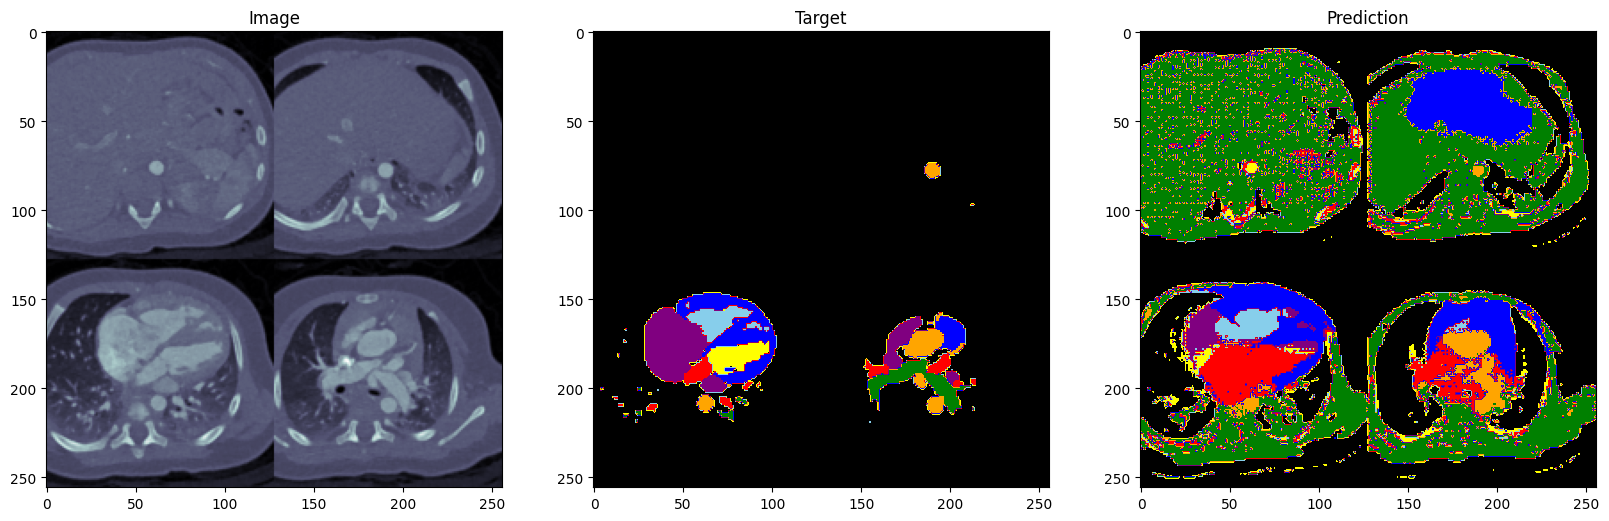

In [ ]:
import matplotlib.pyplot as plt
import skimage
from heart_seg_app.utils.visualization import create_custom_cmap

def show_result(inputs : torch.Tensor, targets : torch.Tensor, outputs : torch.Tensor, start, end, step):
    inputs = inputs.clone().cpu()
    targets = targets.clone().cpu()
    outputs = outputs.clone().cpu()
    
    cmap, norm = create_custom_cmap(label_values, colors)
        
    fig, ax = plt.subplots(1, 3, figsize=(20, 20))
    ax[0].imshow(skimage.util.montage(inputs.T[start:end:step]), cmap="bone")
    ax[1].imshow(skimage.util.montage(targets.T[start:end:step]), cmap=cmap, norm=norm)
    ax[2].imshow(skimage.util.montage(outputs.T[start:end:step]), cmap=cmap, norm=norm)
    ax[0].set_title("Image")
    ax[1].set_title("Target")
    ax[2].set_title("Prediction")
    plt.show()

inputs = inputs.squeeze(dim=1)
targets = torch.argmax(targets, dim=1)
outputs = torch.argmax(outputs, dim=1)
show_result(inputs[0], targets[0], outputs[0], 0, 100, 25)